In [23]:
import numpy as np
import pandas as pd
import os
from sklearn.cluster import KMeans
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
data_path = "/kaggle/input/rsna-bone-age/"  # Replace with your RSNA dataset path
image_folder = os.path.join(data_path, "boneage-training-dataset/boneage-training-dataset")

In [25]:
train_df = pd.read_csv(os.path.join(data_path, "boneage-training-dataset.csv"))


In [26]:
sample_df = train_df.sample(n=500, random_state=42)


In [27]:
def preprocess_images(df, img_dir, target_size=(256, 256)):
    images = []
    for img_id in df['id']:
        img_path = os.path.join(img_dir, f"{img_id}.png")
        img = load_img(img_path, target_size=target_size, color_mode="rgb")
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)  # Normalize for Xception
        images.append(img_array)
    return np.array(images)

In [28]:
images = preprocess_images(sample_df, image_folder)


In [29]:
base_model = Xception(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
features = base_model.predict(images)
features_flat = features.reshape(features.shape[0], -1)  # Flatten features

I0000 00:00:1732686570.123098    6586 service.cc:145] XLA service 0x7f9dd8001f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732686570.124005    6586 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732686570.124012    6586 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/16 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step

I0000 00:00:1732686582.871230    6586 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 680ms/step


In [36]:
# Scale features for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_flat)

In [38]:
# Dimensionality Reduction using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=50, random_state=42)  # Retain top 50 principal components
pca_features = pca.fit_transform(scaled_features)

In [39]:
n_clusters = 3  # Assuming 3 bone density classes: Low (Osteoporosis), Normal, High
kmeans = KMeans(n_clusters=n_clusters, random_state=42, init='k-means++', max_iter=300)
clusters = kmeans.fit_predict(pca_features)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [40]:
sample_df['bone_density_class'] = clusters


In [41]:
class_mapping = {0: "Normal Density", 1: "Osteoporosis (Low Density)", 2: "High Density"}
sample_df['bone_density_label'] = sample_df['bone_density_class'].map(class_mapping)

In [42]:
print(sample_df[['id', 'bone_density_label']].head())


          id          bone_density_label
8140   10613              Normal Density
11389  14253                High Density
1945    3546  Osteoporosis (Low Density)
7981   10430              Normal Density
9359   11986              Normal Density


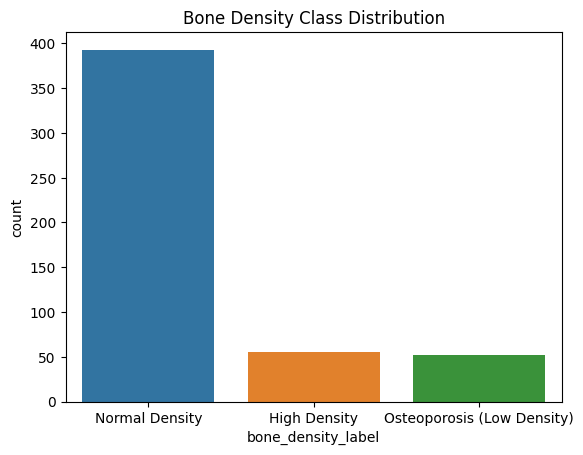

In [43]:
sns.countplot(x='bone_density_label', data=sample_df)
plt.title("Bone Density Class Distribution")
plt.show()

In [44]:
train_features, val_features, train_labels, val_labels = train_test_split(
    pca_features, clusters, test_size=0.2, random_state=42
)

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [46]:

classifier = Sequential([
    Dense(128, activation='relu', input_shape=(train_features.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(n_clusters, activation='softmax')  # Output 3 classes
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [48]:
history = classifier.fit(
    train_features, train_labels,
    validation_data=(val_features, val_labels),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 307ms/step - accuracy: 0.3377 - loss: 32.4585 - val_accuracy: 0.7800 - val_loss: 7.8158
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6981 - loss: 15.1764 - val_accuracy: 0.7800 - val_loss: 6.6685
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7265 - loss: 11.7022 - val_accuracy: 0.8100 - val_loss: 3.5379
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7405 - loss: 12.2242 - val_accuracy: 0.9000 - val_loss: 1.6736
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7535 - loss: 8.9562 - val_accuracy: 0.9200 - val_loss: 1.0088
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7110 - loss: 8.9629 - val_accuracy: 0.9200 - val_loss: 0.7919
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7973 - loss: 5.7204 - val_accuracy: 0.9200 - val_loss: 0.8308
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8012 - loss: 4.4125 - val_accuracy: 0.9300 - val

In [49]:
val_predictions = classifier.predict(val_features)
val_predictions = np.argmax(val_predictions, axis=1)
print("Classification Report:")
print(classification_report(val_labels, val_predictions, target_names=list(class_mapping.values())))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Classification Report:
                            precision    recall  f1-score   support

            Normal Density       0.94      0.99      0.96        76
Osteoporosis (Low Density)       0.78      0.78      0.78         9
              High Density       0.91      0.67      0.77        15

                  accuracy                           0.92       100
                 macro avg       0.87      0.81      0.84       100
              weighted avg       0.92      0.92      0.92       100



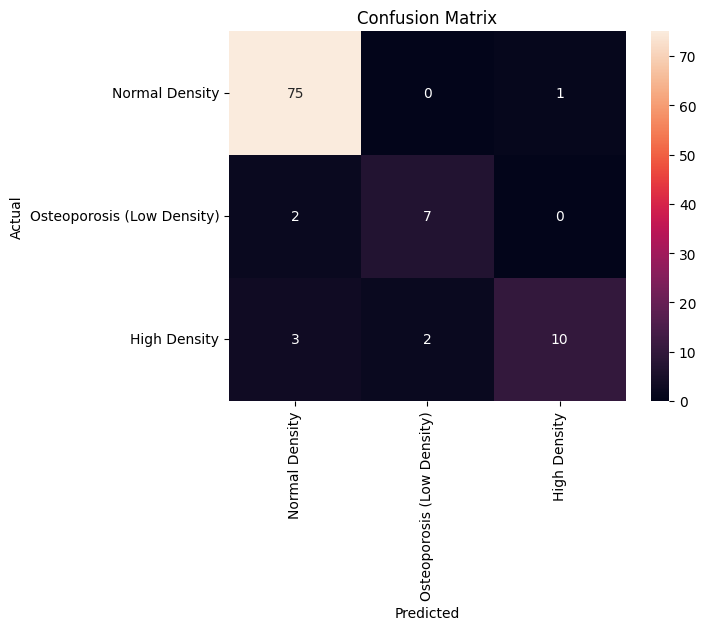

In [50]:
conf_matrix = confusion_matrix(val_labels, val_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_mapping.values(), yticklabels=class_mapping.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [67]:
uploaded_image_path = "/kaggle/input/osteporos2/osteporosis2.jpg"  # Replace with your uploaded image path
uploaded_img = load_img(uploaded_image_path, target_size=(256, 256), color_mode="rgb")
uploaded_img_array = img_to_array(uploaded_img)
uploaded_img_array = preprocess_input(uploaded_img_array)
uploaded_features = base_model.predict(np.expand_dims(uploaded_img_array, axis=0))
uploaded_features_flat = scaler.transform(uploaded_features.reshape(1, -1))
uploaded_pca_features = pca.transform(uploaded_features_flat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [68]:
uploaded_prediction = classifier.predict(uploaded_pca_features)
predicted_class = np.argmax(uploaded_prediction)
predicted_label = class_mapping[predicted_class]
print(f"Predicted Bone Density Class: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted Bone Density Class: Osteoporosis (Low Density)


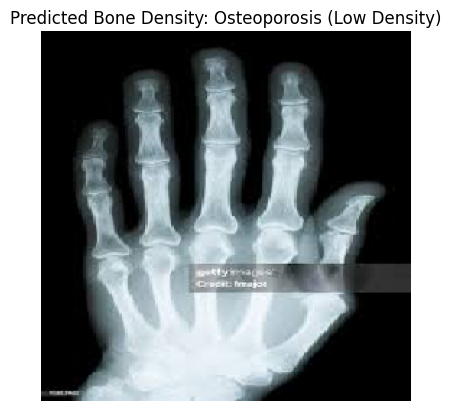

In [69]:
plt.imshow(uploaded_img)
plt.title(f"Predicted Bone Density: {predicted_label}")
plt.axis('off')
plt.show()

In [70]:
# Save the model
classifier.save('/kaggle/working/bone_density_model.h5')  # Specify your desired file path
print("Model saved successfully.")


Model saved successfully.


In [71]:
# Save the model
classifier.save('/kaggle/working/bone_density_model.keras')  # Specify your desired file path
print("Model saved successfully.")


Model saved successfully.
